<a href="https://colab.research.google.com/github/meliy-meyada/Tensorflow-Deep-Learning-and-Artificial-Intelligence/blob/master/TF2_0_Servings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Tensorflow
!pip install -q tensorflow
import tensorflow as tf
print(tf.__version__)

2.8.2


In [2]:
# Here is a service IP address in a json

import requests
r = requests.get('https://api.ipify.org?format=json')
j = r.json()
print(j)

{'ip': '35.201.159.250'}


In [3]:
# More imports

import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [4]:
# Load in the data

fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, X_test / 255.0
print("X_train.shape: ", x_train.shape)
print("X_test.shape: ", x_test.shape)

X_train.shape:  (60000, 28, 28)
X_test.shape:  (10000, 28, 28)


In [5]:
# The data is only 2D
# Convolution expects height x width x color
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)

(60000, 28, 28, 1)


In [6]:
# Number of classes
K = len(set(y_train))
print("number of classes: ", K)

number of classes:  10


In [7]:
# Bulit the model usingthe functional API
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)


model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656

In [8]:
# Compile and fit

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Epoch 1/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.5194 - accuracy: 0.8089 - val_loss: 0.3904 - val_accuracy: 0.8509
Epoch 2/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3571 - accuracy: 0.8666 - val_loss: 0.3607 - val_accuracy: 0.8614
Epoch 3/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3128 - accuracy: 0.8827 - val_loss: 0.3136 - val_accuracy: 0.8870
Epoch 4/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2821 - accuracy: 0.8945 - val_loss: 0.3041 - val_accuracy: 0.8864
Epoch 5/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2539 - accuracy: 0.9035 - val_loss: 0.3037 - val_accuracy: 0.8902
Epoch 6/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2322 - accuracy: 0.9113 - val_loss: 0.2926 - val_accuracy: 0.8976
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2151 - accuracy: 0.9184 - val_loss: 0.2831 - val_accuracy:

In [9]:
# Save the model to a temporary dir
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSave model: ')
!ls -l {export_path}

export_path = /tmp/1


Already saved a model, cleaning up


Save model: 
total 160
drwxr-xr-x 2 root root   4096 Sep 14 07:41 assets
-rw-r--r-- 1 root root 153507 Sep 14 07:41 saved_model.pb
drwxr-xr-x 2 root root   4096 Sep 14 07:41 variables


In [10]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: TensorSpe

In [11]:
# https://www.tensorflow.org/tfx/tutorials/serving/rest_simple
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update
!apt-get install tensorflow-model-server

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   151k      0 --:--:-- --:--:-- --:--:--  151k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic 

In [27]:
import os
os.environ["MODEL_DIR"] = MODEL_DIR

In [33]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [34]:
!tail server.log

tensorflow_model_server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.28' not found (required by tensorflow_model_server)
tensorflow_model_server: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by tensorflow_model_server)
tensorflow_model_server: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by tensorflow_model_server)


In [26]:
# Label mapping

labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

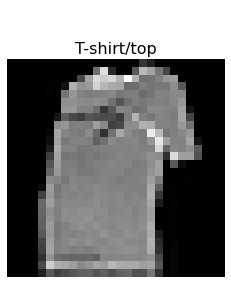

In [16]:
def show(idx, title):
  plt.figure()
  plt.imshow(X_test[idx].reshape(28,28), cmap='gray')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

i = np.random.randint(0, len(x_test))
show(i, labels[y_test[i]])

In [17]:
# # Format some data to pass to the server
# {
#     "signature_name": "serving_default",
#     "instances": [ an N x H x W x C list ],
# }

# import json
# data = json.dumps({"signature_name": "serving_default", "instances": x_test[0:3].tolist()})
# print(data)

import json
data = json.dumps({"signature_name": "serving_default", "instances": x_test[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


In [ ]:
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
j = r.json()
print(j.keys())
print(j)

In [ ]:
# It look like a 2-D array
pred = np.array(j['prediction'])
print(pred.shape)

In [ ]:
# Get the predicted classes
pred = pred.argmax(axis=1)

In [ ]:
# Map them back to str
pred =[labels[i] for i in pred]
print(pred)

In [ ]:
# Get the true labels
actual =[labels[i] for i in y_test[:3]]
print(actual)

In [ ]:
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

In [ ]:
# Allows select a model by versions

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

In [ ]:
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Flatten()(x)
x = Dense(K, activation='softmax')(x)

model2 = Model(i, x)
model2.summary()

In [ ]:
# Compile and fit

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

In [ ]:
# Save the model2

version = 2
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSave model: ')
!ls -l {export_path}

In [ ]:
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

In [ ]:
eaders = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/3:predict', data=data, headers=headers)
j = r.json()